<a href="https://colab.research.google.com/github/KBasdeo/CIFAR10-Image_Class/blob/main/Food101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision 101 Project via Transfer Learning

* Created on Google Colab
* Utilizes feature extraction and fine tuning methods on EfficientNetB0 model
* Utilizes precision training with Google's Tesla T4 GPU
* Link to helper functions: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py 

In [1]:
# Make sure I'm using Tesla T4 (only GPU on Google Colab with a high enough Compute Score for mixed precision training)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ffe8ab5f-eaa8-8568-5f17-a13d89d5f937)


In [2]:
# Download helper functions created in Zero To Mastery Machine Learning Course
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-24 15:08:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-24 15:08:37 (107 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the project
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Using TensorFlow to download Dataset

In [4]:
# Get dataset from TensorFlow
import tensorflow_datasets as tfds

In [5]:
# Load Dataset
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete3KDPQ1/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete3KDPQ1/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Data Exploration

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [7]:
# Get class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
# Singling out one sample of data
one_sample = train_data.take(1)
one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
# More info about training sample
for image, label in one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food 101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food 101 (tensor form): 16
  Class name (str form): cheesecake
  


## Plot an image from dataset

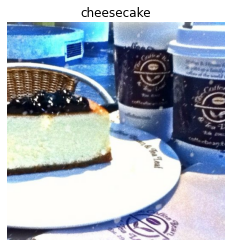

In [10]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);

## Create Preprocessing Function for Images

* Convert datatype from `unint8` to `float32`
* Reshapes image to (224, 224, 3)

In [11]:
# Import tensorflow
import tensorflow as tf

In [12]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  # image = image/255. # Scale image values (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [13]:
# Checking to see preprocess_img works as planned
preprocessed_img = preprocess_img(image, label)[0]
print(f'Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}')
print(f' Image after preprocessing: \n{preprocessed_img[:2]}...,\nshape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}')

Image before preprocessing:
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>
 Image after preprocessing: 
[[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]...,
shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch and Prepare Datasets

Speeding up data input pipeline for model

In [14]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [15]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create Modelling Callbacks to Track Model Performance

* TensorBoard callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [16]:
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

## Setting Up Mixed Precision Training

* Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [17]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision training

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


## Initial Feature Extraction Model

* First Attempt
* Just feature extraction, no fine tuning
* EfficientNetB0 base model

In [18]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [19]:
# Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [20]:
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220724-151934
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8201 - accuracy: 0.5583WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 190s 72ms/step - loss: 1.8201 - accuracy: 0.5583 - val_loss: 1.2292 - val_accuracy: 0.6772
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2928 - accuracy: 0.6652WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 164s 68ms/step - loss: 1.2928 - accuracy: 0.6652 - val_loss: 1.1184 - val_accuracy: 0.6992
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1426 - accuracy: 0.7019WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 177s 74ms/step - loss: 1.1426 - accuracy: 0.7019 - val_loss: 1.0990 - val_accuracy: 0.7079


In [21]:
# Evaluating model on entire test data
model.evaluate(test_data)

790/790 [==============================] - 50s 63ms/step - loss: 1.0923 - accuracy: 0.7056


[1.0923086404800415, 0.7055841684341431]

In [22]:
# Saving first model
model.save('drive/MyDrive/Models/101_food_classes_project_model_1')

INFO:tensorflow:Assets written to: drive/MyDrive/Models/101_food_classes_project_model_1/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Models/101_food_classes_project_model_1/assets


In [23]:
# Checking to make sure model saved correctly
loaded_model = tf.keras.models.load_model('drive/MyDrive/Models/101_food_classes_project_model_1')

loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 50s 62ms/step - loss: 1.0923 - accuracy: 0.7056


[1.0923094749450684, 0.7055841684341431]

## Attempting to improve Model with Fine-Tuning
* I will unfreeze some of the layers in the EfficientNetB0 model alllowing them to be trainable to improve accuracy.
* Initial model achived ~70% accuracy. Will try to beat this.

In [24]:
# Only making the last five layers trainable as the model was pretty accurate already
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [26]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
pooling_layer True
dense True
softmax_float32 True


In [28]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[1].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [29]:
# Fine tune for 3 more epochs
fine_tune_epochs = 6

# Fit the model with callbacks
history_101_food_classes_fine_tune = model.fit(train_data, 
                                                     epochs=fine_tune_epochs,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_fine_tune"),
                                                                model_checkpoint],
                                                    initial_epoch=history_101_food_classes_feature_extract.epoch[-1])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220724-154028
Epoch 3/6
2367/2368 [============================>.] - ETA: 0s - loss: 1.0454 - accuracy: 0.7264WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 172s 71ms/step - loss: 1.0455 - accuracy: 0.7264 - val_loss: 1.0661 - val_accuracy: 0.7090
Epoch 4/6
2368/2368 [==============================] - ETA: 0s - loss: 0.9720 - accuracy: 0.7440WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 170s 71ms/step - loss: 0.9720 - accuracy: 0.7440 - val_loss: 1.0652 - val_accuracy: 0.7142
Epoch 5/6
2368/2368 [==============================] - ETA: 0s - loss: 0.9156 - accuracy: 0.7582WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 169s 71ms/step - loss: 0.9156 - accuracy: 0.7582 - val_loss: 1.0584 - val_accuracy: 0.7092
Epoch 6/6
2367/2368 [============================>.] - ETA: 0s - loss: 0.8668 - accuracy: 0.7718WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 165s 69ms/step - loss: 0.8668 - accuracy: 0.7718 - val_loss: 1.0541 - val_accuracy: 0.7161


In [49]:
# Evaluating model results on all test data
model.evaluate(test_data)

790/790 [==============================] - 43s 54ms/step - loss: 4.6109 - accuracy: 0.0242


[4.61093282699585, 0.024237623438239098]

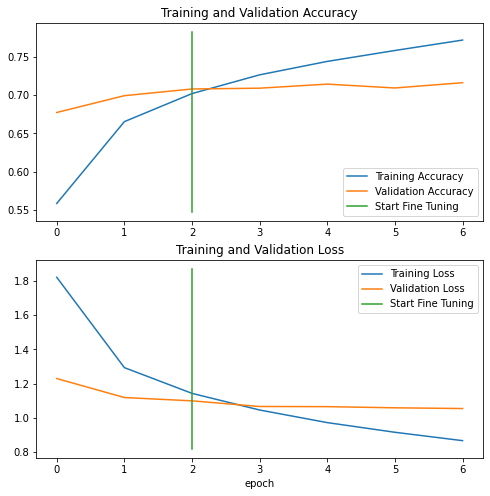

In [48]:
# Comparing model histories
compare_historys(original_history=history_101_food_classes_feature_extract, 
                 new_history=history_101_food_classes_fine_tune,
                 initial_epochs=3)

## Conclusion

* Unfortunately fine-tuning the model produced similar results
* Other measures could be taken such as getting more data, training for more epochs, or adding data augmentation